In [33]:
"""
    Apartado de importaciones y preparaciones iniciales
"""
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
import warnings
import os
import json

RUTA_RECODE_DATASER ="recodes/"
RUTA_DATASET_INICIAL = "datasets/"
RUTA_DATASET_LIMPIADO = "01_dataset_limpiado/"
RUTA_DATASET_FRECUENCIA_GRUPOS = "02_frecuencia_grupos/"
RUTA_DATASET_GRUPOS_CONSOLIDADO = "04_consolidado_grupos/"
RUTA_DATASET_TOTALES_ENFERMEDADES = "05_frecuencias_totales/"

COLUMNAS_INICIALES_INTERES = ["ucr358", "sex", "ager52", "race"]
COLUMNAS_GRUPOS_INTERES = ["ucr358", "sex", "ager52", "race", "count", "year"]

NOMBRE_ARCHIVO_CONSOLIDADO_FREC_GRUPO = "frecuencia_grupos_enfermedades.csv"
NOMBRE_ARCHIVO_CONSOLIDADO_TOTALES = "recuencias_grupos_enfermedades_total.csv"

COLUMNA_TOTAL = "count"

# Creando directorios en caso no se encuentren en el root
if(not os.path.exists(RUTA_DATASET_INICIAL)): os.makedirs(RUTA_DATASET_INICIAL)
if(not os.path.exists(RUTA_DATASET_LIMPIADO)): os.makedirs(RUTA_DATASET_LIMPIADO)
if(not os.path.exists(RUTA_DATASET_FRECUENCIA_GRUPOS)): os.makedirs(RUTA_DATASET_FRECUENCIA_GRUPOS)
if(not os.path.exists(RUTA_DATASET_GRUPOS_CONSOLIDADO)): os.makedirs(RUTA_DATASET_GRUPOS_CONSOLIDADO)
if(not os.path.exists(RUTA_DATASET_TOTALES_ENFERMEDADES)): os.makedirs(RUTA_DATASET_TOTALES_ENFERMEDADES)

In [2]:
"""
    01 - Algoritmo de limpiado y extraccion

    Objetivo:
    *) En base a los datasets iniciales, que cuentan con columnas innecesarias que se no se ocuparan en la investigacion
       el algoritmo de limpiado y extraccion busca guardar los datasets, solo con las columnas que se buscan estudiar
"""
carpeta_inicial = RUTA_DATASET_INICIAL
carpeta_destino = RUTA_DATASET_LIMPIADO
columnas_interes = COLUMNAS_INICIALES_INTERES
archivos_convertir = os.listdir(carpeta_inicial)

for archivo in archivos_convertir:
    print("Convirtiendo: " + archivo)
    df_muertes = pd.read_csv(carpeta_inicial + archivo)
    df_resumido = df_muertes[columnas_interes]

    # Eliminar filas que no cuentan con valor para las columnas estudiadas
    df_resumido.dropna(subset=columnas_interes)

    df_resumido.to_csv(carpeta_destino + archivo, index=False)
    print("Dataset almacenado")

Convirtiendo: 2019.csv


C:\Users\guill\AppData\Local\Temp\ipykernel_13076\458158401.py:15: DtypeWarning: Columns (66,69,72,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df_muertes = pd.read_csv(carpeta_inicial + archivo)


Dataset almacenado
Convirtiendo: 2020.csv


C:\Users\guill\AppData\Local\Temp\ipykernel_13076\458158401.py:15: DtypeWarning: Columns (66,69,72,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df_muertes = pd.read_csv(carpeta_inicial + archivo)


Dataset almacenado


In [13]:
"""
    02 - Algoritmo de agrupamiento

    Objetivo:
    *) En el paso anterior se realizó el proceso de extraccion y limpiado de datos para cada uno de los años 
       que se buscan estudiar, para este paso se busca saber la frecuencia de los grupos de interes, en este
       caso un grupo esta formado por:

        -> Genero
        -> Edad
        -> Raza
        -> Enfermedad
"""

carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_destino = RUTA_DATASET_FRECUENCIA_GRUPOS
columnas_interes = COLUMNAS_INICIALES_INTERES
archivos_convertir = os.listdir(carpeta_inicial)

count = 0

for archivo in archivos_convertir:
    print("Procesando agrupaciones para: " + archivo)
    df_muertes = pd.read_csv(carpeta_inicial + archivo)
    grupo = df_muertes.groupby(columnas_interes).size().sort_values(ascending=False)
    df_agrupado = grupo.reset_index().rename(columns = { 0: COLUMNA_TOTAL }).sort_values(by = columnas_interes)
    # Agregando el año de todas las filas (para distinguir el año de procedencia de la data)
    df_agrupado["year"] = int(archivo.split(".")[0])
    df_agrupado.to_csv(carpeta_destino + archivo, index=False)
    count = df_agrupado[COLUMNA_TOTAL].sum()
    print("Totales de muertes en el año: " + str(count))
    print("Agrupaciones almacenadas")

Procesando agrupaciones para: 2019.csv
Procesando agrupaciones para: 2020.csv


,ucr358,sex,ager52,race
0,208,F,43,3
1,429,M,38,1
2,429,F,33,1
3,74,F,37,2
4,211,M,39,1
...,...,...,...,...
3390273,214,M,40,2
3390274,159,M,38,2
3390275,51,M,39,2
3390276,331,M,36,2


In [5]:
"""
    03 - Algoritmo de estandarización
"""
import json

def cargar_json(ruta):
    with open(ruta, 'r') as archivo:
        return json.load(archivo)

def comparar_jsons(json1, json2):
    claves_a_comparar = ["358_cause_recode", "sex", "age_recode_52"]
    diferencias = []

    for clave in claves_a_comparar:
        valores_json1 = json1.get(clave, {})
        valores_json2 = json2.get(clave, {})

        if valores_json1 != valores_json2:
            diferencias_clave = {
                "Clave": clave,
                "Diferencias": []
            }

            for k, v1 in valores_json1.items():
                v2 = valores_json2.get(k)
                if v1 != v2:
                    diferencias_clave["Diferencias"].append({k: {"Diccionario 2019": v1, "Diccionario 2020": v2}})

            diferencias.append(diferencias_clave)

    return diferencias

# Rutas de los archivos JSON
ruta_json1 = 'recodes/recode2019.json'
ruta_json2 = 'recodes/recode2020.json'

# Cargar los JSON
json1 = cargar_json(ruta_json1)
json2 = cargar_json(ruta_json2)

# Comparar el contenido de las claves especificadas
resultados_comparacion = comparar_jsons(json1, json2)

# Mostrar las diferencias puntuales, si las hay
if resultados_comparacion:
    print("Datos puntuales diferentes en los diccionarios:")
    for diferencia in resultados_comparacion:
        print(f"Clave: {diferencia['Clave']}")
        for elemento in diferencia["Diferencias"]:
            print(f"  {elemento}")
else:
    print("No se encontraron diferencias entre los dos JSON.")

Datos puntuales diferentes en los diccionarios:
Clave: 358_cause_recode
  {'019': {'Diccionario 2019': 'Diptheria', 'Diccionario 2020': 'Diphtheria'}}


In [6]:
"""
    04 - Algoritmo de consolidación y agrupación final
    
    Objetivo:
    *) En los pasos previos, hemos obtenido los datasets que representan las frecuencias de las enfermedades de un
       año determinado para nuestras columnas de interes (Genero, Edad, Raza, Enfermedad), este paso simplemente busca
       consolidar en un archivo el resultado de las frecuencias de cada uno de los años de estudio
"""
carpeta_inicial = RUTA_DATASET_FRECUENCIA_GRUPOS
carpeta_destino = RUTA_DATASET_GRUPOS_CONSOLIDADO
columnas_interes = COLUMNAS_GRUPOS_INTERES
archivos_convertir = os.listdir(carpeta_inicial)

primer_archivo = True
df_grupos_consolidado = ""
count = 0

for archivo in archivos_convertir:
    if (primer_archivo):
        df_grupos_consolidado = pd.read_csv(carpeta_inicial + archivo)
        primer_archivo = False
    else:
        df_grupo_anio = pd.read_csv(carpeta_inicial + archivo)
        df_grupos_consolidado = pd.concat([df_grupos_consolidado, df_grupo_anio], axis=0, ignore_index=True)

# Almacenando consolidado final de enfermedades por anio
df_grupos_consolidado.to_csv(carpeta_destino + NOMBRE_ARCHIVO_CONSOLIDADO_FREC_GRUPO, index=False)
count = df_grupos_consolidado[COLUMNA_TOTAL].sum()
print("Totales de muertes para los años procesados: " + str(count))
print("Consolidado de frecuencias por enfermedad almacenado exitosamente")

Totales de muertes para los años procesados: 6251801
Consolidado de frecuencias por enfermedad almacenado exitosamente


In [7]:
"""
    05 - Algoritmo de análisis

    Objetivo:
    *) Ahora que ya tenemos las frecuencias de muerte para cada grupo, procedemos a ejecutar el algoritmo de probabilidad
       de muerte de una persona por una enfermedad, el algoritmo es el siguiente:
    
    P(muerte persona, dada [ENTRADA]) =     # de personas que han muerto dada [ENTRADA]
                                        ---------------------------------------------------
                                        # de personas que han muerto para el [GENERO] dado

    Entrada:
    *) Genero
    *) Rango de edad
    *) Raza
    *) Enfermedad
"""

carpeta_inicial = RUTA_DATASET_GRUPOS_CONSOLIDADO
carpeta_destino = RUTA_DATASET_TOTALES_ENFERMEDADES
columnas_interes = COLUMNAS_INICIALES_INTERES
archivo_entrada = NOMBRE_ARCHIVO_CONSOLIDADO_FREC_GRUPO
archivo_salida = NOMBRE_ARCHIVO_CONSOLIDADO_TOTALES

"""
    FUNCION CALCULADORA DE PROBABILIDAD DE MUERTE
"""
def probabilidad_muerte(df, v_genero, v_rango_edad, v_raza, v_enfermedad):
    # Paso 1: Chequear si tenemos la cantidad de personas muertas, dada las variables de entrada
    grupo_interes = df[
        (df["sex"] == v_genero) 
        & (df["ager52"] == v_rango_edad) 
        & (df["race"] == v_raza)
        & (df["ucr358"] == v_enfermedad)]
    
    if (not grupo_interes.empty):
        # Paso 2: ya que encontramos al grupo que pertenece, determinamos en total para el genero, las personas
        #           que mueren, para conocer la probabilidad que dicha persona podria morir, dada las condiciones
        
        # determinando el numero de personas muertas para un genero dado, para una enfermedad dada
        grupo_total = df[(df["sex"] == genero) & (df["ucr358"] == enfermedad)]
        
        total_muertes = grupo_total[COLUMNA_TOTAL].sum()
        muertes_grupo_interes = grupo_interes[COLUMNA_TOTAL].sum()

        # Print para propositos de debugging
        print("Numero de muertes para la enfermedad entre todos los " +  genero + " :" + str(total_muertes))
        print("Numero de muertes para el grupo al que pertenece la persona: " +  str(muertes_grupo_interes))
        print("Probabilidad de que la persona muera: " + str(muertes_grupo_interes/total_muertes))
        print("")

        return muertes_grupo_interes/total_muertes
    else:
        # -1 = data no fue encontrada para el grupo de interes
        return -1
    

"""
    Codigo ejecucion
"""

# Paso 1: Cargamos el dataset, y lo reagrupamos de tal manera que, se sumen la columna "count" para obtener el total
#         de muertos por enfermedad para cada grupo de interes
df_frecuencias_enfermedades_anio = pd.read_csv(carpeta_inicial + archivo_entrada)
df_frecuencias_enfermedades_total = df_frecuencias_enfermedades_anio.groupby(columnas_interes)[COLUMNA_TOTAL].sum().reset_index().sort_values(by = [COLUMNA_TOTAL])
df_frecuencias_enfermedades_total.to_csv(carpeta_destino + archivo_salida, index = False)


# Paso 2: Calculamos las probabilidades para las enfermedades

# Variables de entrada
genero = "F"
rango_edad = 44
raza = 1
enfermedad = 175

resultado = probabilidad_muerte(df_frecuencias_enfermedades_total, genero, rango_edad, raza, enfermedad)
print("Probabilidad de que la persona muera por la enfermedad (%): " + str(resultado*100))
print("Total de muertes por todos los datasets: " + str(df_frecuencias_enfermedades_total[COLUMNA_TOTAL].sum()))


Numero de muertes para la enfermedad entre todos los F :159675
Numero de muertes para el grupo al que pertenece la persona: 39807
Probabilidad de que la persona muera: 0.24930014091122593

Probabilidad de que la persona muera por la enfermedad (%): 24.930014091122594
Total de muertes por todos los datasets: 6251801


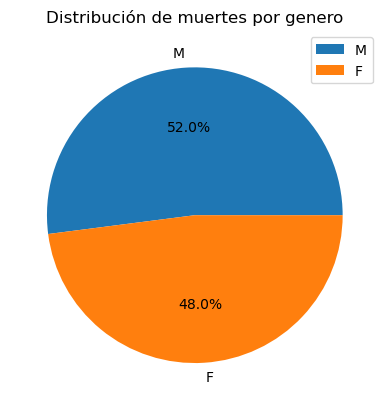

In [3]:
# Grafico 1: Muertes por genero para cada año estudiado
carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""
df_grafico_1 = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_grafico_1 = df_consolidado
frecuencias = df_grafico_1["sex"].value_counts()

plt.pie(frecuencias, labels=frecuencias.index, autopct="%1.1f%%")
plt.title("Distribución de muertes por genero")
plt.legend(frecuencias.index)

plt.show()

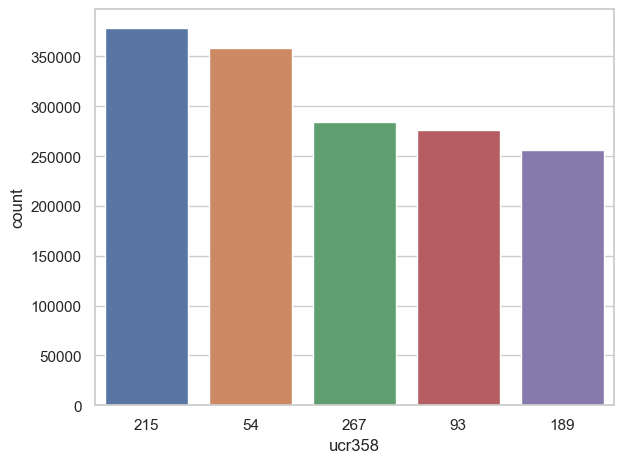

In [12]:
# Grafico 2: Grafico de las 5 enfermedades con mayor numero de muertes en los 2 años de estudio
carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_consolidado["illness"] = df_consolidado.apply(lambda row: 
                       str(row["ucr358"]) + "="
                       + json_diccionario["358_cause_recode"][str(row["ucr358"]).zfill(3)][:15]
                       , axis=1)


order = df_consolidado["ucr358"].value_counts().index
countplot = sns.countplot(df_consolidado, x="ucr358", order=order[:5])
countplot.tick_params(axis='x', rotation=0)
df_grafico_2 = df_consolidado
plt.tight_layout()
plt.show()

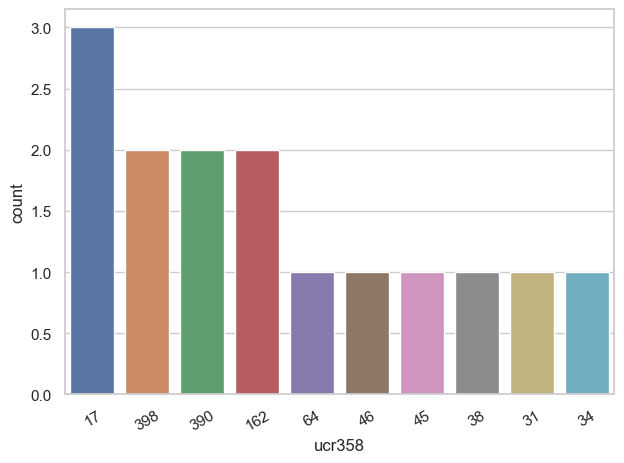

In [15]:
# Grafico 3: Grafico de las enfermedades con el menor numero de muertes, para los 2 años estudiados

carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_consolidado["illness"] = df_consolidado.apply(lambda row: 
                       str(row["ucr358"]) + "="
                       + json_diccionario["358_cause_recode"][str(row["ucr358"]).zfill(3)][:15]
                       , axis=1)

order = df_consolidado["ucr358"].value_counts().index
countplot = sns.countplot(df_consolidado, x="ucr358", order=order[-10:])
countplot.tick_params(axis='x', rotation=30)
df_grafico_3 = df_consolidado
plt.tight_layout()
plt.show()

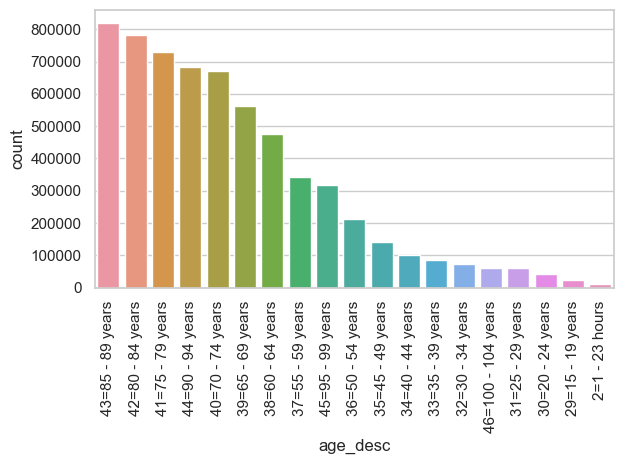

In [16]:
# Grafico 4: Grafico de rango de edades con el mayor numero de muertes, para los 2 años estudiados
carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_consolidado["age_desc"] = df_consolidado.apply(lambda row: 
                       str(row["ager52"]) + "="
                       + json_diccionario["age_recode_52"][str(row["ager52"])][:15]
                       , axis=1)


order = df_consolidado["age_desc"].value_counts().index
countplot = sns.countplot(df_consolidado, x="age_desc", order=order[:19])
countplot.tick_params(axis='x', rotation=90)
df_grafico_4 = df_consolidado
plt.tight_layout()
plt.show()

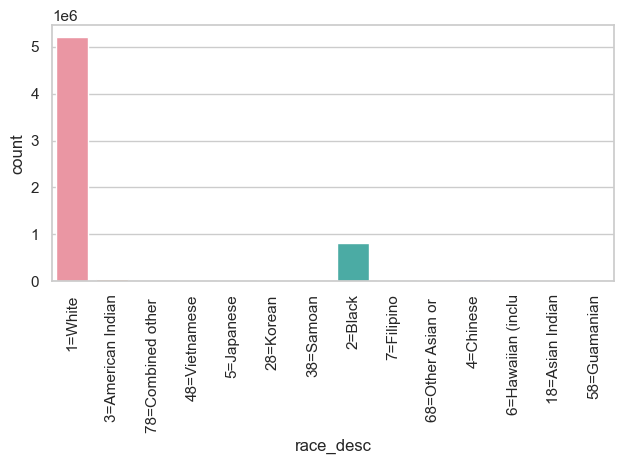

In [17]:
# Grafico 5: Grafico de muertes por raza
carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_consolidado["race_desc"] = df_consolidado.apply(lambda row: 
                       str(row["race"]) + "="
                       + json_diccionario["race"][str(row["race"]).zfill(2)][:15]
                       , axis=1)


order = df_consolidado["race_desc"].value_counts().index
countplot = sns.countplot(df_consolidado, x="race_desc")
countplot.tick_params(axis='x', rotation=90)
df_grafico_5 = df_consolidado
plt.tight_layout()
plt.show()

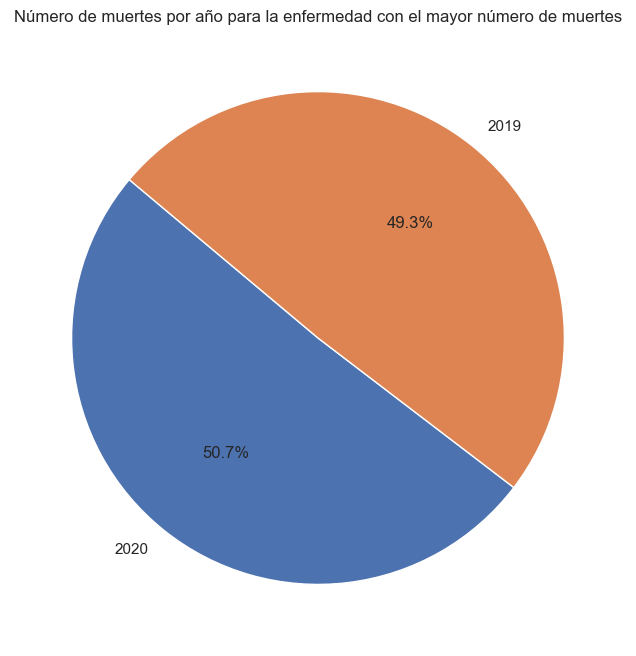

In [41]:
# Gráfico 6 número de muertes por año, para la enfermedad con el mayor número de muertes. 

carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]
enfermedad_estudiada = 215

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado["year"] = anio_estudio
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_anio["year"] = anio_estudio
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_enfermedad_seleccionada = df_consolidado[df_consolidado["ucr358"] == enfermedad_estudiada]
df_grafico_6 = df_enfermedad_seleccionada
data_counts = df_grafico_6['year'].value_counts()

# Crear un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Número de muertes por año para la enfermedad con el mayor número de muertes')
plt.show()

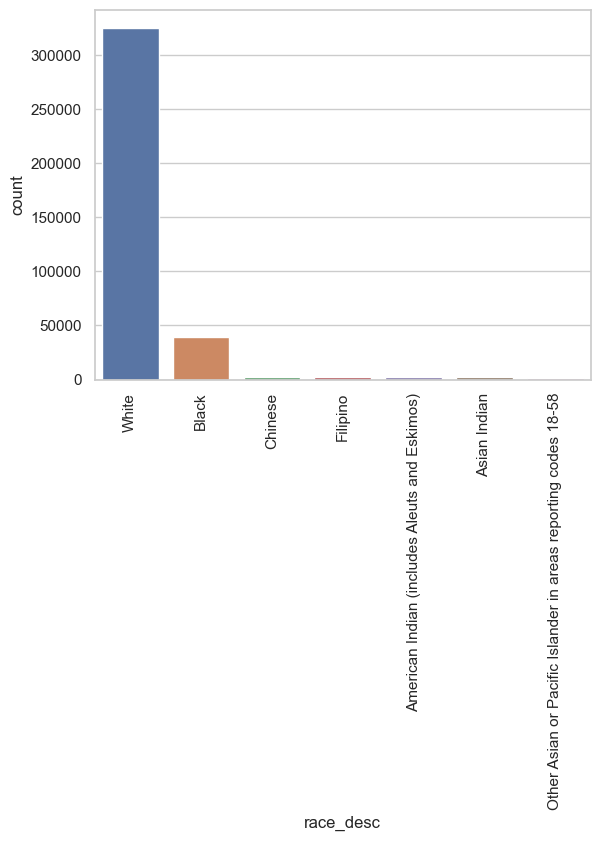

In [40]:
# Grafico 7: número de muertes por raza, para la enfermedad con el mayor número de muertes 
carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]
enfermedad_estudiada = 215

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_enfermedad_seleccionada = df_consolidado[df_consolidado["ucr358"] == enfermedad_estudiada]
df_enfermedad_seleccionada["race_desc"] = df_enfermedad_seleccionada.apply(lambda row: 
                       json_diccionario["race"][str(row["race"]).zfill(2)]
                       , axis=1)


order = df_enfermedad_seleccionada["race_desc"].value_counts().index
countplot = sns.countplot(df_enfermedad_seleccionada, x="race_desc", order=order[:7])
countplot.tick_params(axis='x', rotation=90)
df_grafico_7 = df_enfermedad_seleccionada
#plt.tight_layout()
plt.show()


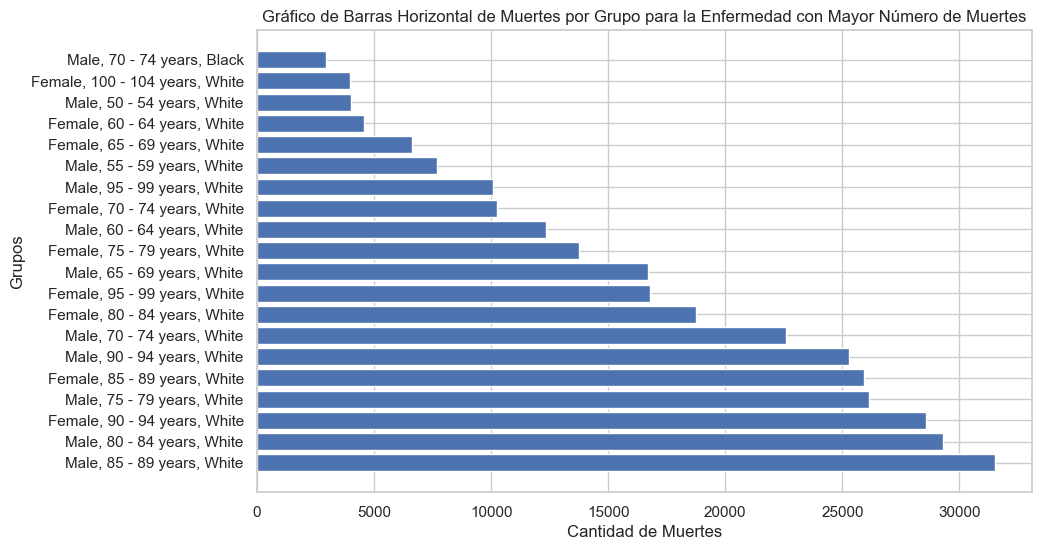

In [37]:
# Grafico 8: Para la enfermedad con el mayor nuero de muertes, conocer 
# los grupos que representan la mayor cantidad de muertes
carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_diccionario = RUTA_RECODE_DATASER
anios_estudio = [2019, 2020]
enfermedad_estudiada = 215

archivo_diccionario = open(carpeta_diccionario + "recode" + str(anios_estudio[0]) + ".json")
json_diccionario = json.load(archivo_diccionario)

primer_archivo = True
df_consolidado = ""

for anio_estudio in anios_estudio:
    if (primer_archivo):
        df_consolidado = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        primer_archivo = False
    else:
        df_anio = pd.read_csv(carpeta_inicial + str(anio_estudio) + ".csv")
        df_consolidado = pd.concat([df_consolidado, df_anio], axis=0, ignore_index=True)

df_enfermedad_seleccionada = df_consolidado[df_consolidado["ucr358"] == enfermedad_estudiada]
df_enfermedad_seleccionada["group"] = df_enfermedad_seleccionada.apply(lambda row: 
                       json_diccionario["Sex"][str(row["sex"])] + ", "
                       + json_diccionario["age_recode_52"][str(row["ager52"])] + ", "
                       + json_diccionario["race"][str(row["race"]).zfill(2)]
                       , axis=1)


conteo_por_grupo = df_enfermedad_seleccionada["group"].value_counts()

# Crear un gráfico de barras horizontal con Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(conteo_por_grupo.index[:20], conteo_por_grupo[:20])
plt.xlabel("Cantidad de Muertes")
plt.ylabel("Grupos")
plt.title("Gráfico de Barras Horizontal de Muertes por Grupo para la Enfermedad con Mayor Número de Muertes")
plt.show()



In [21]:
# Verificaciones de los graficos

# Grafico 1: Muertes por genero para cada año estudiado
df_verificacion_grafico_1 = df_grafico_1.groupby(["sex"]).size().reset_index(name="counts")
print("Valores para el grafico 1, agrupado por sexo")
print(df_verificacion_grafico_1)
print("Suma total: " + str(df_verificacion_grafico_1["counts"].sum()))
print("\n\n\n")

# Grafico 2: Grafico de las 5 enfermedades con mayor numero de muertes en los 2 años de estudio
df_verificacion_grafico_2 = df_grafico_2.groupby(["illness"]).size().reset_index(name="counts")
df_verificacion_grafico_2 = df_verificacion_grafico_2.sort_values(by="counts",ascending=False)
print("Valores para el grafico 2, agrupado por enfermedad")
print(df_verificacion_grafico_2)
print("Suma total: " + str(df_verificacion_grafico_2["counts"].sum()))
print("\n\n\n")

# Grafico 3: Grafico de las enfermedades con el menor numero de muertes, para los 2 años estudiados
df_verificacion_grafico_3 = df_grafico_3.groupby(["illness"]).size().reset_index(name="counts")
df_verificacion_grafico_3 = df_verificacion_grafico_3.sort_values(by="counts",ascending=True)
print("Valores para el grafico 3, agrupado por enfermedad")
print(df_verificacion_grafico_3)
print("Suma total: " + str(df_verificacion_grafico_3["counts"].sum()))
print("\n\n\n")

# Grafico 4: Grafico de rango de edades con el mayor numero de muertes, para los 2 años estudiados
df_verificacion_grafico_4 = df_grafico_4.groupby(["age_desc"]).size().reset_index(name="counts")
df_verificacion_grafico_4 = df_verificacion_grafico_4.sort_values(by="counts",ascending=False)
print("Valores para el grafico 4, agrupado por rango de edad")
print(df_verificacion_grafico_4)
print("Suma total: " + str(df_verificacion_grafico_4["counts"].sum()))
print("\n\n\n")

# Grafico 5: Grafico de muertes por raza
df_verificacion_grafico_5 = df_grafico_5.groupby(["race_desc"]).size().reset_index(name="counts")
df_verificacion_grafico_5 = df_verificacion_grafico_5.sort_values(by="counts",ascending=False)
print("Valores para el grafico 5, agrupado por raza")
print(df_verificacion_grafico_5)
print("Suma total: " + str(df_verificacion_grafico_5["counts"].sum()))
print("\n\n\n")

# Gráfico 6 número de muertes por año, para la enfermedad con el mayor número de muertes. 
df_verificacion_grafico_6 = df_grafico_6.groupby(["year"]).size().reset_index(name="counts")
df_verificacion_grafico_6 = df_verificacion_grafico_6.sort_values(by="counts",ascending=False)
print("Valores para el grafico 6, agrupado por año")
print(df_verificacion_grafico_6)
print("Suma total: " + str(df_verificacion_grafico_6["counts"].sum()))
print("\n\n\n")

# Grafico 7: número de muertes por raza, para la enfermedad con el mayor número de muertes 
df_verificacion_grafico_7 = df_grafico_7.groupby(["race_desc"]).size().reset_index(name="counts")
df_verificacion_grafico_7 = df_verificacion_grafico_7.sort_values(by="counts",ascending=False)
print("Valores para el grafico 7, agrupado por raza")
print(df_verificacion_grafico_7)
print("Suma total: " + str(df_verificacion_grafico_7["counts"].sum()))
print("\n\n\n")

# Grafico 8: Para la enfermedad con el mayor nuero de muertes, conocer 
# los grupos que representan la mayor cantidad de muertes
df_verificacion_grafico_8 = df_grafico_8.groupby(["group"]).size().reset_index(name="counts")
df_verificacion_grafico_8 = df_verificacion_grafico_8.sort_values(by="counts",ascending=False)
print("Valores para el grafico 8, agrupado por caracteristicas")
print(df_verificacion_grafico_8)
print("Suma total: " + str(df_verificacion_grafico_8["counts"].sum()))
print("\n\n\n")

Valores para el grafico 1, agrupado por sexo
  sex   counts
0   F  2998860
1   M  3252941
Suma total: 6251801




Valores para el grafico 2, agrupado por enfermedad
                 illness  counts
97   215=All other forms  378704
312   54=All other and u  358099
138  267=Other chronic o  284621
343   93=Of trachea, bro  276111
75   189=Alzheimer's dis  255827
..                   ...     ...
239            38=Rabies       1
305   46=Rubella (German       1
206      34=Typhus fever       1
318   64=Schistosomiasis       1
304           45=Measles       1

[350 rows x 2 columns]
Suma total: 6251801




Valores para el grafico 3, agrupado por enfermedad
                 illness  counts
305   46=Rubella (German       1
206      34=Typhus fever       1
304           45=Measles       1
318   64=Schistosomiasis       1
184   31=Other infection       1
..                   ...     ...
75   189=Alzheimer's dis  255827
343   93=Of trachea, bro  276111
138  267=Other chronic o  284621
312   54=A